In [61]:
!pip install -U gym box2d-py > /dev/null 2>&1
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so': Permission denied
E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [62]:
import gym
import random
import copy
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from tqdm import tqdm

from IPython.display import clear_output
import os
import Box2D
import pickle
path_to_project = 'storage/'

In [63]:
import pdb
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


BUFFER_SIZE = int(5e4)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 1e-3        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, gamma=GAMMA, tau=TAU,
                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=LR_ACTOR, 
                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=LR_CRITIC, 
                 weight_decay=WEIGHT_DECAY, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=actor_lr)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, critic_fc1_units, critic_fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, critic_fc1_units, critic_fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=critic_lr, weight_decay=weight_decay)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
#         pdb.set_trace()
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
#         with torch.no_grad():
#             Q_targets -= Q_targets.mean()
#             Q_targets /= Q_targets.std()
#             Q_expected -= Q_expected.mean()
#             Q_expected /= Q_expected.std()
        critic_loss = F.mse_loss(Q_targets, Q_expected)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [64]:
def ddpg(env, agent, n_episodes=1500, max_t=200, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    return scores


def ddpg_with_testing(env, agent, n_episodes=1500, max_t=200, n_test_episodes=10, test_freq=100, clear_freq=300):
    scores_deque = deque(maxlen=100)
    scores = []
    test_scores = []
    
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        # pdb.set_trace()
        if i_episode % clear_freq == 0:
            clear_output()
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
            if i_episode % test_freq != 0:
                print('')
            
        if i_episode % test_freq == 0:
            print('')
            test_scores_deque = deque(maxlen=100)
            test_scores_per_episode = []
            for i_test_episode in range(1, n_test_episodes+1):
                test_agent = copy.copy(agent)
                state = env.reset()
                agent.reset()
                score = 0
                for t in range(max_t):
                    action = test_agent.act(state, add_noise=False)
                    next_state, reward, done, _ = env.step(action)
                    state = next_state
                    score += reward
                    if done:
                        break 
                test_scores_deque.append(score)
                test_scores_per_episode.append(score)
                print('\rTest Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_test_episode, np.mean(test_scores_deque), score), end="")
            test_scores.append(np.average(test_scores_per_episode))
            print('\nTest From Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(test_scores_deque))) 
            print('=================================================')
            
    return scores, test_scores

# Lunar Lander

In [65]:
cart_path = os.path.join(path_to_project, 'ddpg_lander_tasks')
data_path = os.path.join(cart_path, 'data')
models_path = os.path.join(cart_path, 'models')
plots_path = os.path.join(cart_path, 'plots')
class Variables:
    SEED=42
    NUM_SEEDS=5
    NUM_TASKS=5
    NUM_EPISODES=1500

## Baseline

In [31]:
env = gym.make('LunarLanderContinuous-v2')

env.seed(Variables.SEED)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

agent = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.001,
             actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
             critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
             weight_decay=0.0001, buffer_size=int(1e6), batch_size=64)

In [32]:
scores, test_scores = ddpg_with_testing(env, agent, n_episodes=1500, max_t=1000, test_freq=50)

Episode 1500	Average Score: -186.94	Score: -195.57
Test Episode 10	Average Score: -95.42	Score: -192.22
Test From Episode 1500	Average Score: -95.42


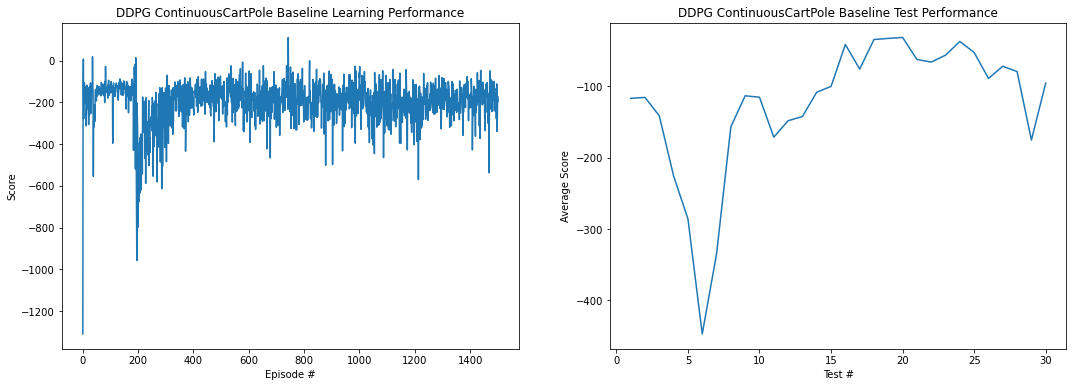

In [33]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('DDPG ContinuousCartPole Baseline Learning Performance')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax = fig.add_subplot(122)
plt.plot(np.arange(1, len(test_scores)+1), test_scores)
plt.title('DDPG ContinuousCartPole Baseline Test Performance')
plt.ylabel('Average Score')
plt.xlabel('Test #')
# plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

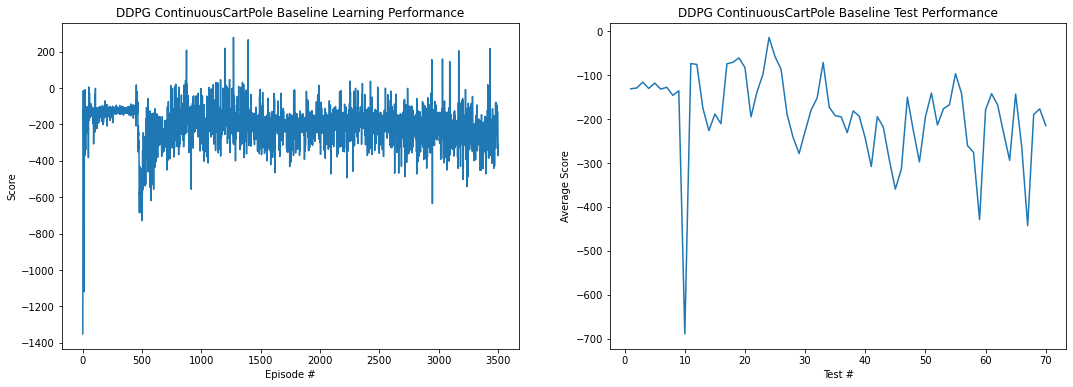

In [48]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('DDPG ContinuousCartPole Baseline Learning Performance')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax = fig.add_subplot(122)
plt.plot(np.arange(1, len(test_scores)+1), test_scores)
plt.title('DDPG ContinuousCartPole Baseline Test Performance')
plt.ylabel('Average Score')
plt.xlabel('Test #')
# plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

In [34]:
torch.save(agent.actor_local.state_dict(), os.path.join(models_path, 'actor_local.pth'))
torch.save(agent.actor_target.state_dict(), os.path.join(models_path, 'actor_target.pth'))
torch.save(agent.critic_local.state_dict(), os.path.join(models_path, 'critic_local.pth'))
torch.save(agent.critic_target.state_dict(), os.path.join(models_path, 'critic_target.pth'))

# New Tasks

In [66]:
def sample_lander_tasks(num_tasks, random_state):
    mass = random_state.normal(loc=4.816666603088379, scale=1, size=num_tasks)
    gravity = random_state.normal(loc=-10, scale=1, size=num_tasks)
    tasks = [{'mass': m, 'gravity': Box2D.b2Vec2(0, g)} for m, g in zip(mass, gravity)]
    return tasks


def set_lander_task(env, task):
    for k, v in task.items():
#         if k == 'mass':
#             env.env.__dict__['lander'].mass = v
        if k == 'gravity':
            env.env.__dict__['world'].gravity = v
    return env

In [67]:
env = gym.make('LunarLanderContinuous-v2')

env.seed(Variables.SEED)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

Variables.NUM_TASKS = 5
Variables.NUM_EPISODES = 1500
Variables.NUM_SEEDS = 2

random_state = np.random.RandomState(Variables.SEED)
tasks = sample_lander_tasks(Variables.NUM_TASKS, random_state)

history_transfer = []
history_scratch = []

test_history_transfer = []
test_history_scratch = []

average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for i, task in tqdm(enumerate(tasks), desc=f'Running {Variables.NUM_TASKS} tasks'):
    scores_transfer_per_seed = []
    scores_scratch_per_seed = []
    
    test_scores_transfer_per_seed = []
    test_scores_scratch_per_seed = []
    for seed in range(Variables.NUM_SEEDS):
        env.seed(seed)
        set_lander_task(env, task)

        # Transfer agent needs to load the weights for each new task
        agent_transfer = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.001,
                                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
                                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
                                 weight_decay=0.0001, buffer_size=int(1e6), batch_size=64)

        agent_transfer.actor_local.load_state_dict(torch.load(os.path.join(models_path, 'actor_local.pth')))
        agent_transfer.actor_target.load_state_dict(torch.load(os.path.join(models_path, 'actor_target.pth')))
        agent_transfer.critic_local.load_state_dict(torch.load(os.path.join(models_path, 'critic_local.pth')))
        agent_transfer.critic_target.load_state_dict(torch.load(os.path.join(models_path, 'critic_target.pth')))
        
        scores_transfer, test_scores_transfer = ddpg_with_testing(env, agent_transfer, n_episodes=Variables.NUM_EPISODES, max_t=750, test_freq=50)
        
        scores_transfer_per_seed.append(scores_transfer)
        test_scores_transfer_per_seed.append(test_scores_transfer)

        # Agent from scratch has its weights initialized randomly for each new task
        agent_scratch = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.001,
                                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
                                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
                                 weight_decay=0.0001, buffer_size=int(1e6), batch_size=64)
        
        scores_scratch, test_scores_scratch = ddpg_with_testing(env, agent_scratch, n_episodes=Variables.NUM_EPISODES, max_t=750, test_freq=50)
        
        scores_scratch_per_seed.append(scores_scratch)
        test_scores_scratch_per_seed.append(test_scores_scratch)

    history_transfer.append(scores_transfer_per_seed)
    history_scratch.append(scores_scratch_per_seed)
    
    test_history_transfer.append(test_scores_transfer_per_seed)
    test_history_scratch.append(test_scores_scratch_per_seed)

Episode 1500	Average Score: -232.30	Score: -424.00
Test Episode 9	Average Score: -94.30	Score: -107.41

Running 5 tasks: 5it [17:37:33, 12690.64s/it]

Test Episode 10	Average Score: -96.69	Score: -118.20
Test From Episode 1500	Average Score: -96.69


In [68]:
for task_idx, task_ls in enumerate(history_transfer):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(history_scratch):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)
                
average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(history_transfer, history_scratch):

    average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    variance_scratch_per_task.append(np.var(ls_scratch, axis=0))
    

for task_idx, task_ls in enumerate(test_history_transfer):
    for seed_idx, test_seed_ls in enumerate(task_ls):
        if len(test_seed_ls) < Variables.NUM_EPISODES // 50:
            diff = Variables.NUM_EPISODES //50 - len(test_seed_ls)
            last_reward = test_seed_ls[-1]
            for i in range(diff):
                test_seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(test_history_scratch):
    for seed_idx, test_seed_ls in enumerate(task_ls):
        if len(test_seed_ls) < Variables.NUM_EPISODES // 50:
            diff = Variables.NUM_EPISODES //50 - len(test_seed_ls)
            last_reward = test_seed_ls[-1]
            for i in range(diff):
                test_seed_ls.append(last_reward)
                
test_average_transfer_per_task = []
test_variance_transfer_per_task = []

test_average_scratch_per_task = []
test_variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(test_history_transfer, test_history_scratch):

    test_average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    test_variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    test_average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    test_variance_scratch_per_task.append(np.var(ls_scratch, axis=0))

In [69]:
tasks_gravity_only = [d['gravity'].y for d in tasks]

In [74]:
plots_path = os.path.join(path_to_project, 'ddpg_lander_tasks/plots')
data_path = os.path.join(path_to_project, 'ddpg_lander_tasks/data')

save = True
if save:
    with open(os.path.join(data_path, 'history_transfer.list'), 'wb') as f:
        pickle.dump(history_transfer, f)
    with open(os.path.join(data_path,'history_scratch.list'), 'wb') as f:
        pickle.dump(history_scratch, f)
    with open(os.path.join(data_path, 'test_history_transfer.list'), 'wb') as f:
        pickle.dump(test_history_transfer, f)
    with open(os.path.join(data_path,'test_history_scratch.list'), 'wb') as f:
        pickle.dump(test_history_scratch, f)
    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(average_transfer_per_task, f)
    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(variance_transfer_per_task, f)
    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(average_scratch_per_task, f)
    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(variance_scratch_per_task, f)
    with open(os.path.join(data_path,'test_average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(test_average_transfer_per_task, f)
    with open(os.path.join(data_path,'test_variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(test_variance_transfer_per_task, f)
    with open(os.path.join(data_path,'test_average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(test_average_scratch_per_task, f)
    with open(os.path.join(data_path,'test_variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(test_variance_scratch_per_task, f)
    with open(os.path.join(data_path, 'tasks_gravity_only.list'), 'wb') as f:
        pickle.dump(tasks_gravity_only, f)
        
load = False
if load:
    # with open(os.path.join(data_path, 'history_transfer.list'), 'rb') as f:
    #     history_transfer = pickle.load(f)

    # with open(os.path.join(data_path,'history_scratch.list'), 'rb') as f:
    #     history_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'rb') as f:
        average_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'rb') as f:
        variance_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'rb') as f:
        average_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'rb') as f:
        variance_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path, 'tasks.list'), 'rb') as f:
        tasks = pickle.load(f)

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


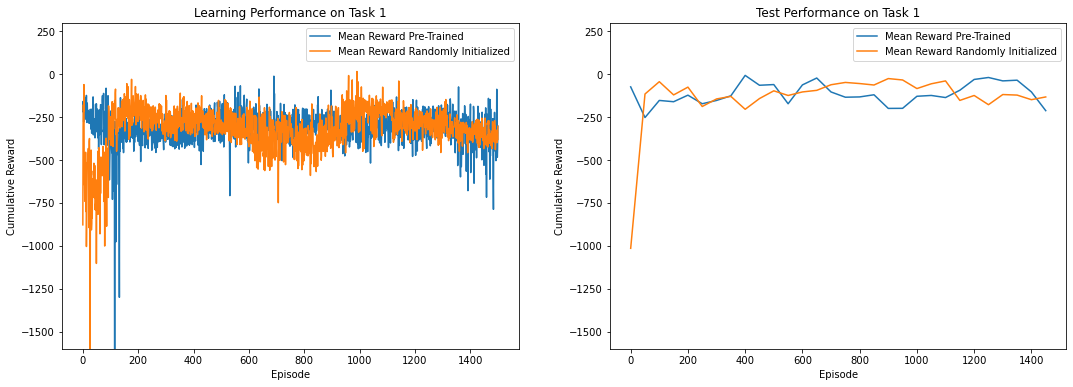

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


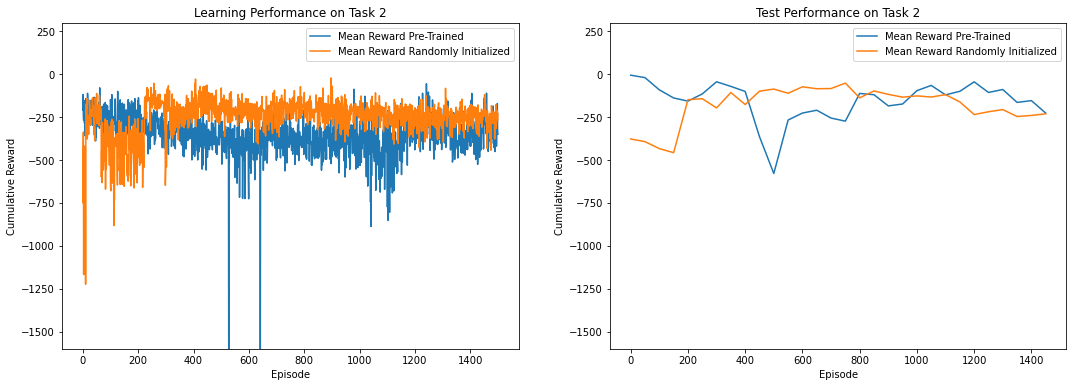

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


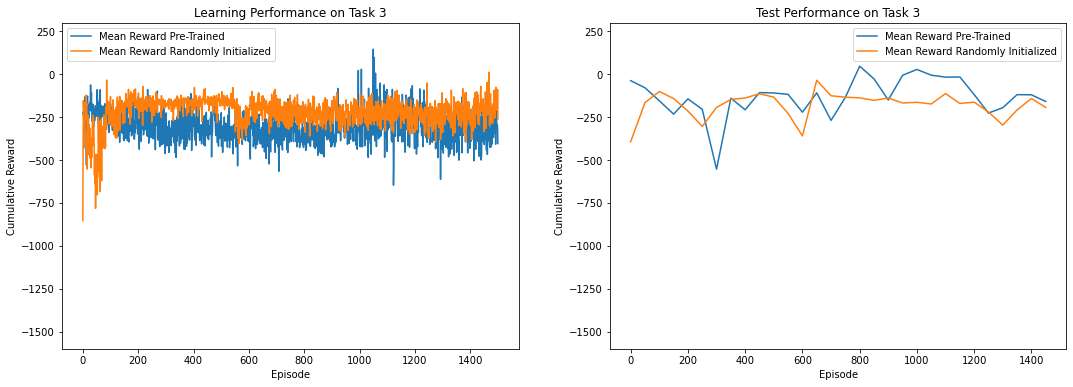

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


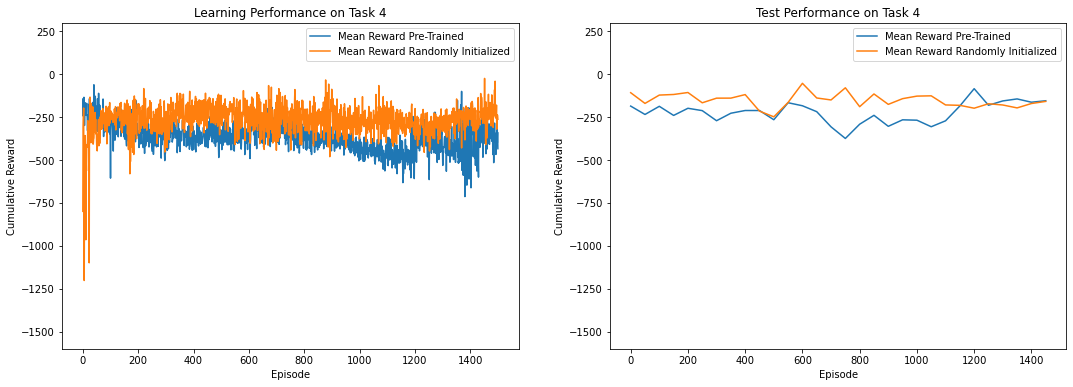

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


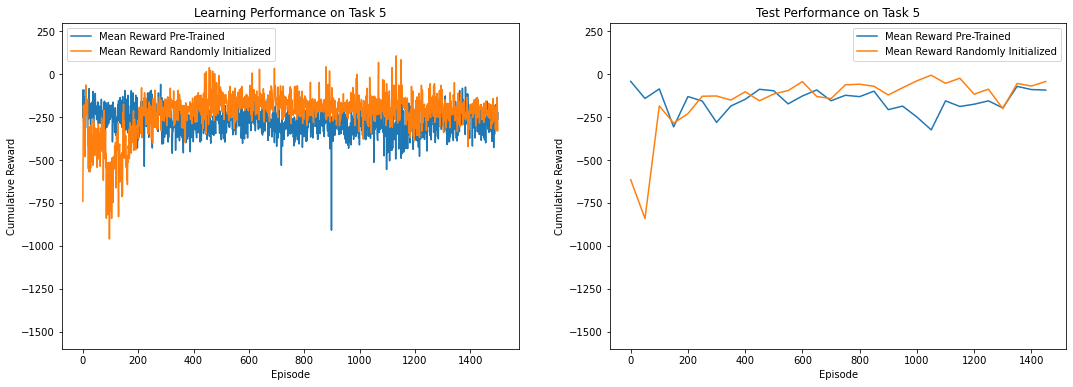

In [75]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    average = average_transfer_per_task[i] 
    plt.plot(average)
    average = average_scratch_per_task[i] 
    plt.plot(average)
    
    plt.title(f"Learning Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'), loc=0)
    plt.ylim((-1600, 300))

    plt.subplot(122)
    average = test_average_transfer_per_task[i] 
    plt.plot([50 * i for i in range(len(average))] ,average)
    average = test_average_scratch_per_task[i] 
    plt.plot([50 * i for i in range(len(average))], average)
    plt.title(f"Test Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'), loc=0)
    plt.ylim((-1600, 300))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}_w_test.png'))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


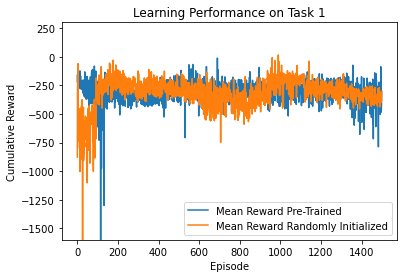

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


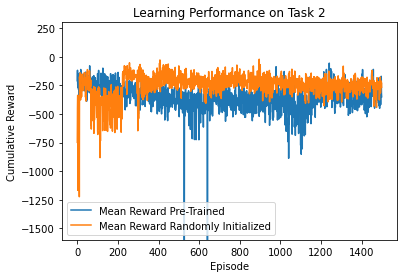

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


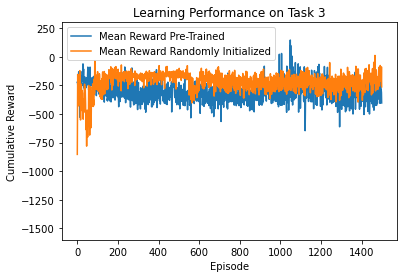

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


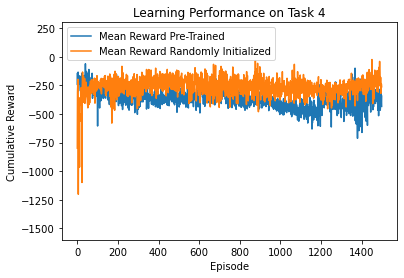

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


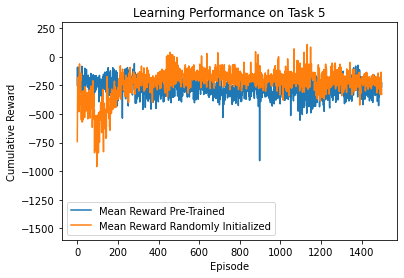

In [72]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    plt.plot(average)

    average = average_scratch_per_task[i] 
    plt.plot(average)

    print(tasks[i])
    plt.title(f"Learning Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.ylim((-1600, 300))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}.png'))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


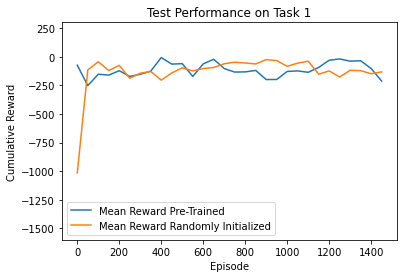

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


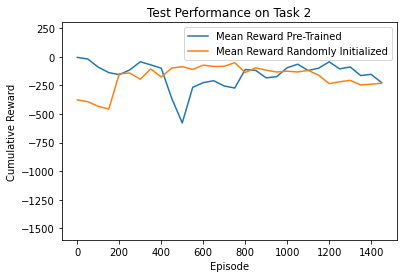

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


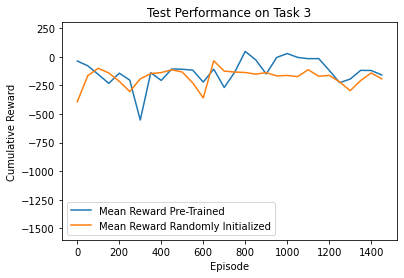

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


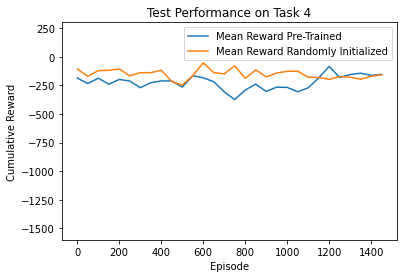

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


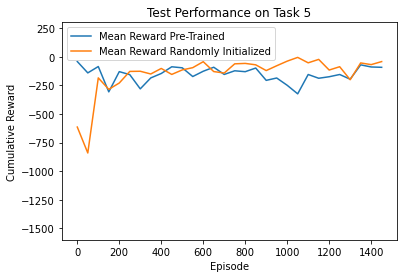

In [73]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])

    average = test_average_transfer_per_task[i] 
    plt.plot([50 * i for i in range(len(average))], average)
    average = test_average_scratch_per_task[i] 
    plt.plot([50 * i for i in range(len(average))], average)
    plt.title(f"Test Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.ylim((-1600, 300))
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'), loc=0)
    plt.savefig(os.path.join(plots_path, f'test_on_task_{i+1}.png'))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


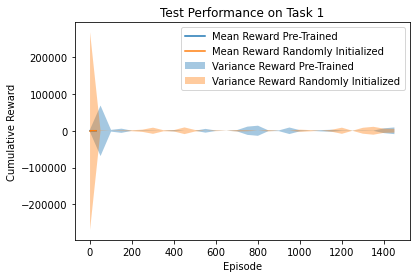

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


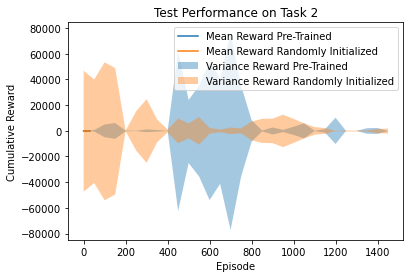

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


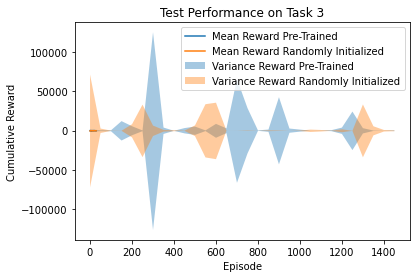

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


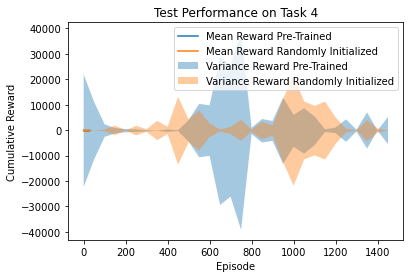

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


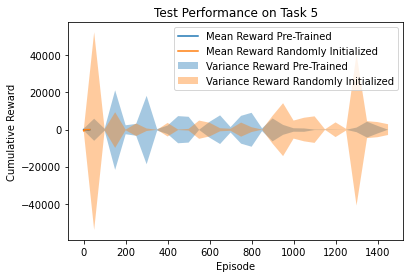

In [78]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = test_average_transfer_per_task[i] 
    variance = test_variance_transfer_per_task[i]

    plt.plot(average)
    plt.fill_between([50 * i for i in range(len(average))], average+variance, average-variance, alpha=0.4)

    average = test_average_scratch_per_task[i] 
    variance = test_variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between([50 * i for i in range(len(average))], average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Test Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_test_on_task_{i+1}.png'))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


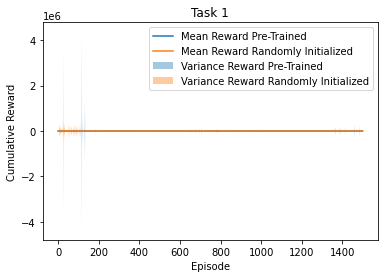

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


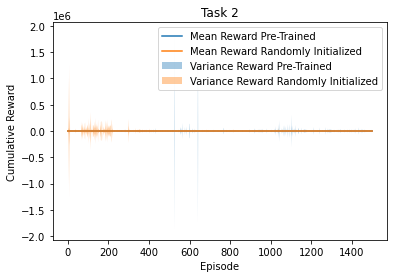

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


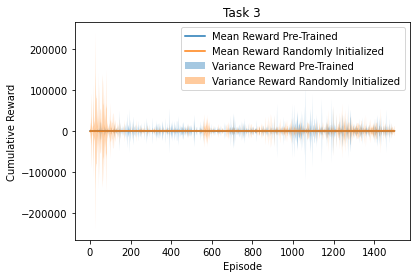

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


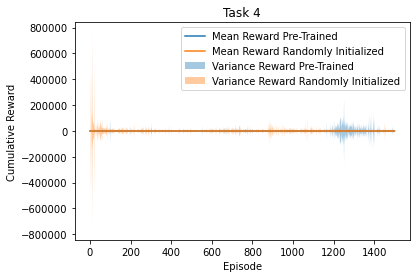

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


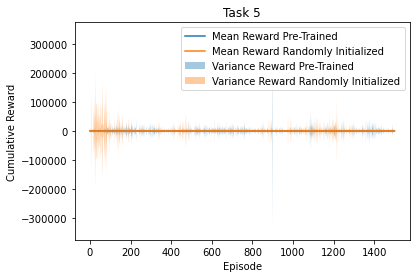

In [76]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize(12,6))
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_test_on_task_{i+1}.png'))
    plt.show()

In [ ]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [ ]:
env = ContinuousCartPoleEnv()

frames = []
for i in range(3):
    state = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(state, add_noise=False)
        state, r, done, _ = env.step(action)
        R += r
        t += 1
    
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())